# 2. Geospatial Data Processing

## Business Problem

You are a geospatial engineer working with a research team focused on
environmental monitoring and climate change analysis. The team has identified
a specific Area of Interest (AOI) that is experiencing significant land use
changes and climatic variations. To support their research, they need a
comprehensive dataset that integrates multiple sources of remote sensing and
meteorological data over the last three months. The datasets required include:

+ Sentinel-1 VV and VH
+ Sentinel-2 NDVI
+ Temperature Data
+ Elevation

You are then needed to integrate these datasets into a unified datacube and
store it in the data format of your choice. Ensure that the datacube is resampled
to the highest spatial resolution available across the datasets.

### Testing the installed packages for the task

In [1]:
import dask.array as da # handle dask arrays
import geopandas as gpd # handle geospatial data frames
from IPython.display import Image # visualize URLs
import pystac_client # connecting to the STAC API
from rasterio.enums import Resampling # perform re-sampling operations
import shapely # create vector objects
import stackstac # build an on-demand STAC data cube
import numpy as np
print("Packages installed successfully 👏")

Packages installed successfully 👏


Define AOI

In [2]:
# Load AOI
import geopandas as gpd
from shapely.geometry import Polygon

# Define AOI directly in Python
aoi_geometry = Polygon([
    (36.306872504019424, 0.5952725839718056),
    (36.306872504019424, 0.7423752404067301),
    (36.45206844566468, 0.7423752404067301),
    (36.45206844566468, 0.5952725839718056),
    (36.306872504019424, 0.5952725839718056)
])

# Convert to GeoDataFrame
aoi_gdf = gpd.GeoDataFrame({"geometry": [aoi_geometry]}, crs="EPSG:4326")

# Get the bounding box of the AOI
bbox = aoi_gdf.total_bounds  # Returns [min_lon, min_lat, max_lon, max_lat]

In [3]:
# !pip install folium

In [4]:
import folium

# Get AOI centroid for better map centering
aoi_center = aoi_gdf.geometry.centroid.iloc[0]
map_center = [aoi_center.y, aoi_center.x]

# Create a Folium map centered at AOI
m = folium.Map(location=map_center, zoom_start=12)

# Add AOI Polygon to the map
aoi_coords = [(y, x) for x, y in aoi_geometry.exterior.coords]  # Convert to (lat, lon) format
folium.Polygon(
    locations=aoi_coords,
    color="blue",
    fill=True,
    fill_opacity=0.4
).add_to(m)

# Display Map
m

C:\Users\LOCATEG5\AppData\Local\Temp\ipykernel_21616\3467622705.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_center = aoi_gdf.geometry.centroid.iloc[0]


## Query STAC API for sentinel and temperature data

In [5]:
import pystac_client
from datetime import datetime, timedelta

# Define STAC API URLs
aws_api_url = "https://earth-search.aws.element84.com/v1"
ms_api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"

# Connect to STAC APIs
client1 = pystac_client.Client.open(aws_api_url)
client2 = pystac_client.Client.open(ms_api_url)

# Define time range (last 3 months)
end_date = datetime.today().replace(day=1)  # First day of current month
start_date = end_date - timedelta(days=90)  # 3 months back
date_range = f"{start_date.strftime('%Y-%m-%d')}/{end_date.strftime('%Y-%m-%d')}"
print("Extracting data from:", date_range)

Extracting data from: 2024-12-01/2025-03-01


In [6]:
# Query Sentinel-1 VV & VH
sentinel1_items = client1.search(
    collections=["sentinel-1-grd"],
    bbox=bbox,
    datetime=date_range
).item_collection()

In [7]:
# Query Sentinel-2 NDVI
sentinel2_items = client1.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=date_range, 
    query={"eo:cloud_cover": {"lt": 10}}
).item_collection()

In [8]:
# Search Copernicus DEM (Elevation Data)
dem_items = client1.search(
    collections=["cop-dem-glo-30"],  # Global 30m resolution DEM 
    bbox=bbox,
).item_collection()

In [9]:
import pystac_client

# Open the client for Planetary Computer API
api_url = 'https://planetarycomputer.microsoft.com/api/stac/v1'
client = pystac_client.Client.open(api_url)

# Find the 'terraclimate' collection
terraclimate_collection = client.get_collection('terraclimate')

# Print metadata about the collection to understand its structure
print(terraclimate_collection)

<CollectionClient id=terraclimate>


In [10]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Get the current date
end_date = datetime.now().date()  # Use only the date portion

# Subtract 3 months from the current date
start_date = end_date - relativedelta(months=3)

# Search for temperature data in the Terraclimate collection for the AOI and time range
search = client.search(
    collections=['terraclimate'],
    datetime=f'{start_date}/{end_date}',  # Ensure the format is YYYY-MM-DD
    bbox=bbox,
)

In [11]:
# Get the items
items = list(search.items())
items

[]

<Axes: >

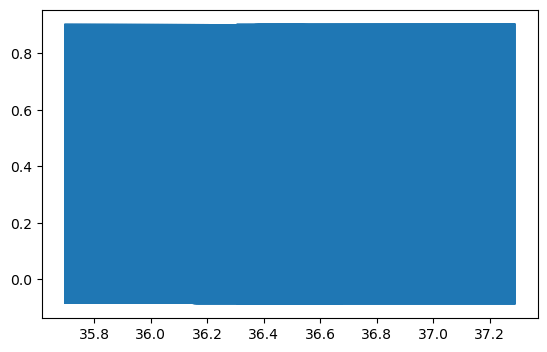

In [12]:
# Explore sentinel-2 items as dataframes.
sentinel_2_items_df = gpd.GeoDataFrame.from_features(sentinel2_items.to_dict(), crs="epsg:4326")
sentinel_2_items_df.plot()

In [13]:
# Filtering sentinel-2 data further with a cloud cover lower than 2% and with a no-data pixel percentage below 10%.
ids = sentinel_2_items_df.loc[
  (sentinel_2_items_df['eo:cloud_cover'] <= 2) &
  (sentinel_2_items_df['s2:nodata_pixel_percentage'] <= 5)
]
sentinel_2_item = sentinel2_items[ids.index[0]]
sentinel_2_item.datetime

datetime.datetime(2025, 2, 26, 8, 0, 20, 128000, tzinfo=tzutc())

In [14]:
thumbnail = sentinel_2_item.assets["thumbnail"].href
Image(url = thumbnail)

### Let's use google earth engine to extract temperature data.

In [15]:
# !pip install tqdm

In [16]:
import ee
import geemap
import pandas as pd
from tqdm import tqdm
import time
import xarray as xr

In [17]:
# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

In [18]:
# Define the ImageCollection for temperature
ic = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate('2024-12-01', '2025-02-28').select('temperature_2m')

In [19]:
# Define your Area of Interest (AOI)
aoi = ee.Geometry.Polygon([
    [[36.306872504019424, 0.5952725839718056], 
     [36.306872504019424, 0.7423752404067301],
     [36.45206844566468, 0.7423752404067301],
     [36.45206844566468, 0.5952725839718056]]
])

In [20]:
# Function to aggregate temperature data by month and convert to xarray
def imagecollection_to_xarray_temperature(image_collection, aoi, scale=1000):
    """Convert an Earth Engine ImageCollection to an xarray DataArray with monthly aggregated temperature data over the provided AOI."""
    
    # Group images by month (using the month of the year as a numeric value)
    def monthly_aggregate(image):
        # Extract the month and year from the 'system:time_start'
        date = ee.Date(image.get('system:time_start'))
        month = date.get('month')  # Extract the month as a numeric value (1-12)
        
        return image.addBands(ee.Image.constant(month).rename('month'))
    
    # Add the 'month' band to each image in the collection
    ic_with_month = image_collection.map(monthly_aggregate)
    
    # Get distinct months in the collection
    months = ic_with_month.aggregate_array('month').distinct()

    # Initialize empty lists to store the monthly mean temperature data
    monthly_temperature_data = []

    # Iterate through each month to calculate the monthly mean temperature
    for month in months.getInfo():
        # Filter the ImageCollection to include only images for the current month
        monthly_images = ic_with_month.filter(ee.Filter.eq('month', month))
        
        # Compute the mean temperature for the current month
        monthly_mean_image = monthly_images.mean().clip(aoi)
        
        # Reduce the image over the specified AOI bounding box to get the mean temperature
        sample = monthly_mean_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,  # Apply the provided AOI region
            scale=scale,
            bestEffort=True,
            maxPixels=1e9
        ).get('temperature_2m')
        
        # Store the temperature value for the current month if valid
        if sample.getInfo() is not None:
            monthly_temperature_data.append(float(sample.getInfo()))  # Ensure float conversion

    # Convert the list of monthly temperatures to a NumPy array
    monthly_temperature_array = np.array(monthly_temperature_data)

    # Convert temperature from Kelvin to Celsius
    monthly_temperature_array = monthly_temperature_array - 273.15  # Kelvin to Celsius conversion

    # Define the date range for the months (as strings)
    dates = [f"2024-{month:02d}" for month in months.getInfo()]

    # Define the coordinates for latitude and longitude based on the AOI
    coords = aoi.coordinates().getInfo()[0]
    lon_min, lat_min = map(float, coords[0])  # Bottom-left corner
    lon_max, lat_max = map(float, coords[2])  # Top-right corner

    # Create lat/lon grid
    lats = np.linspace(lat_min, lat_max, num=10)  # Increase resolution if needed
    lons = np.linspace(lon_min, lon_max, num=10)

    # Now, we need to match the dimensions of the data to the grid:
    # The temperature data is a 1D array, but we need to assign it to a 3D grid (time, latitude, longitude)
    temperature_array = np.tile(monthly_temperature_array, (len(lats), len(lons), 1)).transpose(2, 0, 1)
    
    # Convert to xarray DataArray with the temperature data
    da = xr.DataArray(
        temperature_array, 
        coords={'time': dates, 'latitude': lats, 'longitude': lons},
        dims=['time', 'latitude', 'longitude'],
        name='temperature'
    )

    return da

# Convert the ImageCollection to xarray with monthly mean temperature data
temperature_xarray = imagecollection_to_xarray_temperature(ic, aoi)

# Display the resulting xarray dataset
print(temperature_xarray)

<xarray.DataArray 'temperature' (time: 3, latitude: 10, longitude: 10)> Size: 2kB
array([[[20.66960307, 20.66960307, 20.66960307, 20.66960307,
         20.66960307, 20.66960307, 20.66960307, 20.66960307,
         20.66960307, 20.66960307],
        [20.66960307, 20.66960307, 20.66960307, 20.66960307,
         20.66960307, 20.66960307, 20.66960307, 20.66960307,
         20.66960307, 20.66960307],
        [20.66960307, 20.66960307, 20.66960307, 20.66960307,
         20.66960307, 20.66960307, 20.66960307, 20.66960307,
         20.66960307, 20.66960307],
        [20.66960307, 20.66960307, 20.66960307, 20.66960307,
         20.66960307, 20.66960307, 20.66960307, 20.66960307,
         20.66960307, 20.66960307],
        [20.66960307, 20.66960307, 20.66960307, 20.66960307,
         20.66960307, 20.66960307, 20.66960307, 20.66960307,
         20.66960307, 20.66960307],
        [20.66960307, 20.66960307, 20.66960307, 20.66960307,
         20.66960307, 20.66960307, 20.66960307, 20.66960307,
      

In [21]:
# Print number of images found
print(f"Sentinel-1 images found: {len(sentinel1_items)}")
print(f"Sentinel-2 images found: {len(sentinel2_items)}")
print(f"DEM images found: {len(dem_items)}")

Sentinel-1 images found: 21
Sentinel-2 images found: 39
DEM images found: 1


In [22]:
# Sentinel one stac
s1_stack = stackstac.stack(
    sentinel1_items, 
    assets=["vv", "vh"], 
    resolution=10, 
    epsg=3857, 
    resampling=Resampling.bilinear)

In [23]:
s1_vv = s1_stack.sel(band="vv")
s1_vv_cube = s1_vv.rename('vv')

In [24]:
s1_vh = s1_stack.sel(band="vh")
s1_vh_cube = s1_vh.rename('vh')

In [25]:
# Sentinel two stac
s2_stack = stackstac.stack(
    sentinel2_items, 
    assets=["nir", "red"], 
    resolution=10, 
    epsg=3857, 
    resampling=Resampling.bilinear)

# Compute NDVI
ndvi_cube = (s2_stack.sel(band="nir") - s2_stack.sel(band="red")) / (
    s2_stack.sel(band="nir") + s2_stack.sel(band="red")
)

# Optional: You can name the DataArray to make it clear it's NDVI
ndvi_cube = ndvi_cube.rename('ndvi')

In [26]:
# Convert DEM item to DataCube
dem_cube = stackstac.stack(
    dem_items, 
    resolution=10, 
    epsg=3857, 
    resampling=Resampling.bilinear
)

dem_cube = dem_cube.rename('dem')
# print(f"DEM DataCube shape: {dem_cube.shape}")

In [27]:
# Convert time dimension
s1_vh_cube["time"] = s1_vh_cube["time"].dt.floor("D")
s1_vv_cube["time"] = s1_vv_cube["time"].dt.floor("D")
ndvi_cube["time"] = ndvi_cube["time"].dt.floor("D")

In [28]:
# Aggregate Monthly Means
vh_monthly = s1_vh_cube.groupby("time.month").mean(dim="time")
vv_monthly = s1_vv_cube.groupby("time.month").mean(dim="time")
ndvi_monthly = ndvi_cube.groupby("time.month").mean(dim="time")

In [29]:
temperature_cube = temperature_xarray.rename('temperature')

In [30]:
# Create a mapping for the original time values to the new numeric values
time_mapping = {'2024-12': 1, '2024-01': 2, '2024-02': 3}

# Replace the time coordinate values with the mapped numeric values
temperature_cube = temperature_cube.assign_coords(time=[time_mapping[t] for t in temperature_cube['time'].values])

In [31]:
import rasterio
import pyproj

# Define your CRS (Coordinate Reference System)
crs = "EPSG:4326"  # WGS84 (longitude, latitude)

# Assuming your temperature_da is a DataArray
temperature_cube.attrs['crs'] = crs

# Optionally, you can save the xarray dataset to a NetCDF file (in Celsius)
temperature_cube.to_netcdf("C:/Users/LOCATEG5/amini_technical_assignment/data/monthly_temperature_data_celsius.nc")

In [32]:
import stackstac
import dask.array as da
import xarray as xr

# Merge into a single dataset
datacube = xr.merge([
    vv_monthly, 
    vh_monthly, 
    ndvi_monthly, 
    temperature_cube
    # dem_cube
], compat='override')

C:\Users\LOCATEG5\anaconda3\envs\geospatial_env\lib\site-packages\dask\array\core.py:5092: PerformanceWarning: Increasing number of chunks by factor of 51
  result = blockwise(
C:\Users\LOCATEG5\anaconda3\envs\geospatial_env\lib\site-packages\dask\array\core.py:5092: PerformanceWarning: Increasing number of chunks by factor of 51
  result = blockwise(
C:\Users\LOCATEG5\anaconda3\envs\geospatial_env\lib\site-packages\dask\array\core.py:5092: PerformanceWarning: Increasing number of chunks by factor of 53
  result = blockwise(


In [33]:
datacube

<xarray.Dataset> Size: 203GB
Dimensions:                                  (x: 52155, y: 40451, month: 4,
                                              latitude: 10, longitude: 10,
                                              time: 3)
Coordinates: (12/48)
  * x                                        (x) float64 417kB 3.787e+06 ... ...
  * y                                        (y) float64 324kB -1.325e+05 ......
  * month                                    (month) int64 32B 1 2 3 12
    band                                     <U2 8B 'vv'
    sar:resolution_range                     int32 4B 20
    sar:looks_equivalent_number              float64 8B 4.4
    ...                                       ...
    s2:snow_ice_percentage                   int32 4B 0
    proj:shape                               object 8B {10980}
    gsd                                      int32 4B 10
  * latitude                                 (latitude) float64 80B 0.5953 .....
  * longitude                                (longitude) float64 80B 36.31 .....
  * time                                     (time) int32 12B 1 2 3
Data variables:
    vv                                       (month, y, x) float64 68GB dask.array<chunksize=(1, 1011, 1024), meta=np.ndarray>
    vh                                       (month, y, x) float64 68GB dask.array<chunksize=(1, 1011, 1024), meta=np.ndarray>
    ndvi                                     (month, y, x) float64 68GB dask.array<chunksize=(1, 1005, 987), meta=np.ndarray>
    temperature                              (time, latitude, longitude) float64 2kB ...
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(3786940, -132550, 4308490, 271...
    crs:         epsg:3857
    transform:   | 10.00, 0.00, 3786940.00|\n| 0.00,-10.00, 271960.00|\n| 0.0...
    resolution:  10

### Aligning DEM with Dynamic variables